In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D ##library for 3d projection plots
import scipy.linalg
%matplotlib inline

Sobre unidades:

$ [ \kappa ] = \frac{{mm}^2}{s} $

$ [k_c] = \frac{W}{mm^2 K} $

$[L] = mm $

$ [q] = \frac{W}{m^2} $

Algunos valores:

<b>Cobre:</b> 

Resolvemos haciendo uso de métodos implicitos: Para estos se cambia como se toma la diferencia finita del tiempo (y de las coordenadas tambien). Se llega a un sistema acoplado que hay que resolver a cada paso temporal, este tiene la forma:

$$\textbf{A} U = b $$

Donde $\textbf{A}$ es la matriz de coeficientes (esto incluye dentro a los deltas, el kappa, etc.), U es un vector cuyos elementos son las temperaturas que buscamos hallar para ese paso temporal y b es otro vector que contiene las temperaturas que sepamos de antes (Ya sea del paso anterior, o inicialmente de las condiciones iniciales). Resolviendo paso a paso este sistema podemos hallar U al tiempo que busquemos.

$\textbf{A}$ es una matriz tridiagonal, es relativamente sencillo ver como surge este sistema si se toman a las derivadas con el método de Euler hacia atrás (Backward Euler) y se arma el sistema. De esta forma nos armamos el sistema implicito.

Hay una forma de generalizar todo esto, la llamada "regla $\theta$". Esta forma implica tomar el método explicito (Forward Euler) y el implicito (Backward Euler) al mismo tiempo, agregando un parametro $\theta$ cuyo valor nos indicara que tipo de método estaremos usando. Esta regla se ve de la forma:

$$\frac{u_i^{n+1} - u_i^n}{\Delta t} = \theta G(u_i^{n+1}) + (1-\theta) G(u_i^n) $$

Donde G(u) es un operador espacial (hacemos esto para ahorrarnos escribir toda la diferencia). Notemos que si el primer termino es nulo (osea tomando $\theta = 0$) llegamos al método que tratamos de usar originalmente: El método explicito. En este método podemos despejar con facilidad a $u_i^{n+1}$ en función de las temperaturas en el paso anterior. Si $\theta=1$ estamos en el método puramente implicito, en el que hay auq acudir a la matriz. Finalmente podemos tomar $\theta=\frac{1}{2}$. Este método mezcla un poco de ambos y toma el nombre de "Crank-Nicolson". Siendo un método implicito Crank-Nicolson en incondicionalmente estable, y se debe acudir a resolver un sistema lineal para cada paso, el método es aún mejor que el implicito puro.

Con la regla $\theta$ podemos encontrar un algoritmo general que resuelva la ec. diferencial. Si queremos resolver con el método explicito, implicito, o Crank-Nicolson solo bastara con tomar otro valor de $\theta$. Veamos como se ve de manera expandida:

$$\frac{u_i^{n+1} - u_i^n}{\Delta t} = \alpha \left( \theta \frac{u_{i+1}^{n+1} - 2u_i^{n+1}
+ u_{i-1}^{n+1}}{\Delta x^2}  + (1 - \theta) \frac{u_{i+1}^{n} - 2u_i^{n} + u_{i-1}^{n}}{\Delta x^2} \right) $$

Definiendo al número de Fourier $F = \alpha \frac{\Delta t}{\Delta x^2}$, veamos los coeficientes de la matriz $\textbf{A}$:

$$A_{i,i-1} = -F \theta , \;   A_{i,i} = (1+2F\theta) , \;   A_{i,i+1} = -F \theta$$

y del lado derecho el vector $b$ nos queda:

$$b_i = u_i^n + F (1-\theta) \frac{u_{i+1}^{n} - 2u_i^{n} + u_{i-1}^{n}}{\Delta x^2} $$

Con esto, llenando la matriz con cuidado, se puede resolver un sistema en 1D para la ecuación de calor. No tenemos restricciones en que $\kappa$, ni $dt$ mandarle ya que es estable incondicionalmente. Aún así para $dt$ mas grandes se tiene mas error en general.

Extender esto a 2D se debe hacer con cuidado



<b>Regla $\theta$ para 1D </b>

In [3]:
'''
I = Condición inicial. Puede ser una función de x, o un float/integer.
k = Coeficiente de difusividad térmica. Ojo con las unidades!
L = Longitud de la barra.
N = Número de puntos espaciales.
dt = Intervalo temporal.
T = Tiempo final.
theta = Parametro theta para elegir el método. theta = 0 explicito, theta = 1 implicito, theta = 1/2 Crank-Nicolson.
CI = Contorno izquierdo. CI == N => Contorno Neumann, CI == R => Contorno Robin, CI == D => Contorno Dirichlet.
CD = Contorno derecho, lo mismo que arriba.
qI = Calor entregado/retirado a la izquierda.
qD = Calor entregado/recibido a la derecha.
UD
'''

def solver_uno(I,el,L,N,dt,T,CI,CD,qI=0,qD=0,UI=20,UD=20,theta=0.5):
    
    if el == "Al":
        k = 97
        kt = 0.23
    elif el == "Cu":
        k = 111
        kt = 0.397
    
    qI = -qI
    qD = qD
    
    #Ctes. definidas aca dentro:
    q = 40 #Calor para Neumann.
    h = 1  #Coef. pelicula para Robin.
    
    
    #Definimos los arrays temporal/espacial y sus dt    
    x = np.linspace(0,L,N+1)
    dx = x[1] - x[0]
    
    dt = float(dt)          
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)
    
    F = k * dt/dx**2  #Número de Fourier
    
    u = np.zeros(N+1)   #Temp. desconocida
    u_n = np.zeros(N+1) #Temp. vieja/conocida
    
    #Nos creamos los rangos de iteración
    Ix = range(0,N+1)
    It = range(0,Nt+1)
    
    if isinstance(I, (float,int)):  #Convierte a I en una función cte si I == float/integer
        _I = float(I)
        I = lambda x: _I
    
    #Cargamos la condición inicial.
    for i in Ix: 
        u_n[i] = I(x[i])
        
    #Creamos la matriz y vector del sistema lineal:
    
    A = np.zeros((N+1,N+1))  #Recordemos: N puntos => Sistema de NxN.
    b = np.zeros(N+1)
    
    '''
    Detalle: La matriz A no cambia en el tiempo. La podemos computar fuera del loop temporal. El vector b SI cambia en el tiempo,
    por lo que habrá que computarlo a cada paso.
    '''
    
    #Computando A
    
    if CI == "N":
        A[0,0] = 1 + 2 * theta * F
        A[0,1] = -2 * theta * F
    elif CI == "D":
        A[0,0] = 1
        
    if CD == "N":
        A[N,N]   = 1 + 2*theta*F
        A[N,N-1] = -2*theta*F
    elif CD == "D":
        A[N,N] = 1
    
    for i in Ix[1:-1]:
        A[i,i]   =  1 + 2*theta*F
        A[i,i-1] = -theta*F
        A[i,i+1] = -theta*F
    
    #Loop temporal:
    
    #Hay que actualizar el b, y calcular el nuevo u a cada step.
    for n in It[0:-1]:
        
        #Contornos para b
        if CI == "N":
            b[0] = u_n[0] + (1-theta)*F*(2*u_n[1] - 2*u_n[0] - dx*qI/kt) - theta*F*dx*qI/kt
        elif CI == "D":
            b[0] = UI
        
        
        if CD == "N":
            b[N] = u_n[N] + (1-theta)*F*(2*u_n[N-1] - 2*u_n[N] + dx*qD/kt) + theta*F*dx*qD/kt
        elif CD == "D":
            b[N] = UD
            
        #Computando b
        for i in Ix[1:-1]:
            b[i] = u_n[i] + (1-theta)*F*(u_n[i-1] - 2*u_n[i] + u_n[i+1])
    
        #Una vez computado, resolvemos el sistema lineal:
        
        u = scipy.linalg.solve(A, b)
        
        #Y actualizamos las temperaturas:
        
        u_n, u = u, u_n
        
    #plt.plot(x,u)
    #plt.grid(True)
    #plt.show()
    return x,u

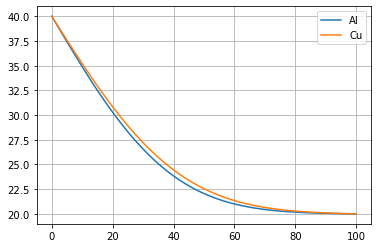

In [4]:
def inicial1d(x):
    return 20

x1, u1 = solver_uno(inicial1d, "Al", L=100, N=100, dt=0.1, T=5, CI="D", CD="D", UI=40,UD=20)
x2, u2 =solver_uno(inicial1d, "Cu", L=100, N=100, dt=0.1, T=5, CI="D", CD="D", UI=40,UD=20)

plt.plot(x1,u1,label="Al")
plt.plot(x2,u2,label="Cu")
plt.grid(True)
plt.legend(loc="best")
plt.show()

<b>Regla $\theta$ en 2D</b>

In [31]:
def solver_dense(
    I, el, f, Lx, Ly, Nx, Ny, dt, T, C1, q=0 ,theta=0.5,
    U_0x=0, U_0y=0, U_Lx=0, U_Ly=0, user_action=None):
    
    """
    Resuelve el problema usando la regla theta. Matriz densa. Resuelve Gauss la matriz.
    """
    #import time; t0 = time.clock()  # Para medir el tiempo de CPU ---> No lo usamos

    if el == "Al":
        k = 97
        kt = 0.23
    elif el == "Cu":
        k = 111
        kt = 0.397
    
    x = np.linspace(0, Lx, Nx+1)       # Mesh en dirección x
    y = np.linspace(0, Ly, Ny+1)       # Mesh en dirección y 
    dx = x[1] - x[0]                   #Los deltas
    dy = y[1] - y[0]

    dt = float(dt)                    # Esto nos evita dividir por integers
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh temporal

    # Números de Fourier en cada dirección (Es simplemente una definición)
    Fx = k*dt/dx**2
    Fy = k*dt/dy**2

    # Si f=0 o None, pedimos que sea f(X)=0. Esta función es la que apareceria en la ecuacion diferencial.
    if f is None or f == 0:
        f = lambda x, y, t: np.zeros((x.size, y.size)) \
            if isinstance(x, np.ndarray) else 0

    u   = np.zeros((Nx+1, Ny+1))      # u desconocido en nuevo tiempo.
    u_n = np.zeros((Nx+1, Ny+1))      # u en el tiempo anterior.

    Ix = range(0, Nx+1)
    Iy = range(0, Ny+1)
    It = range(0, Nt+1)

    # Si los contornos son float/int, los volvemos funciones (en principio pueden ser funcion del tiempo)
    if isinstance(U_0x, (float,int)):
        _U_0x = float(U_0x)  # Make copy of U_0x
        U_0x = lambda t: _U_0x
    if isinstance(U_0y, (float,int)):
        _U_0y = float(U_0y)  # Make copy of U_0y
        U_0y = lambda t: _U_0y
    if isinstance(U_Lx, (float,int)):
        _U_Lx = float(U_Lx)  # Make copy of U_Lx
        U_Lx = lambda t: _U_Lx
    if isinstance(U_Ly, (float,int)):
        _U_Ly = float(U_Ly)  # Make copy of U_Ly
        U_Ly = lambda t: _U_Ly

    # Cargamos condicion inicial en u_n
    for i in Ix:
        for j in Iy:
            u_n[i,j] = I(x[i], y[j])

    # Two-dim coordinate arrays for vectorized function evaluations
    # in the user_action function
    xv = x[:,np.newaxis]
    yv = y[np.newaxis,:]

    if user_action is not None:
        user_action(u_n, x, xv, y, yv, t, 0)

    # Data structures for the linear system
    N = (Nx+1)*(Ny+1)  # no de incognitas
    A = np.zeros((N, N)) #Armando la matriz
    b = np.zeros(N)      #Armando el vector

    # Fill in dense matrix A, mesh line by line
    m = lambda i, j: j*(Nx+1) + i

    # Equation corresponding to mesh point (i,j) has number
    # j*(Nx+1)+i and will contribute to row j*(Nx+1)+i
    # in the matrix.

    # Equations corresponding to j=0, i=0,1,... (u known)
    j = 0
    for i in Ix:
        p = m(i,j);  A[p, p] = 1
    # Loop over all internal mesh points in y diretion
    # and all mesh points in x direction
    for j in Iy[1:-1]:
        
        if C1 == "D":
            i = 0;  p = m(i,j);  A[p, p] = 1   #Contorno Dirichlet
        
       
        elif C1 == "N":
            i=0
            p=m(i,j)
            A[p,p] = 1+2*theta*(Fx+Fy)
            A[p,m(1,j)] = -2*theta*Fx
            A[p,m(i,j-1)] = -theta*Fy
            A[p,m(i,j+1)] = -theta*Fy
        
        for i in Ix[1:-1]:                 #Puntos interiores
            p = m(i,j)
            A[p, m(i,j-1)] = - theta*Fy
            A[p, m(i-1,j)] = - theta*Fx
            A[p, p]        = 1 + 2*theta*(Fx+Fy)
            A[p, m(i+1,j)] = - theta*Fx
            A[p, m(i,j+1)] = - theta*Fy
        i = Nx;  p = m(i,j);  A[p, p] = 1  # contorno       #----> Creo que a la hora de poner otro contorno se modifica esto!
    # Ecuaciones que corresponden a j=Ny, i=0,1,... 
    j = Ny
    for i in Ix:
        p = m(i,j);  A[p, p] = 1

    # loop de tiempo
    for n in It[0:-1]:
        # computa b
        j = 0
        for i in Ix:
            p = m(i,j);  b[p] = U_0y(t[n+1])  # contorno
        for j in Iy[1:-1]:
            
            if C1 == "D":
                i = 0;  p = p = m(i,j);  b[p] = U_0x(t[n+1])  # contorno
                
            elif C1 == "N":
                i = 0; p = p = m(i,j); b[p] = u_n[i,j] + \
                (1-theta)*( Fx*(dx*q/kt - 2*u_n[i,j] + 2*u_n[i+1,j]) + Fy*(u_n[i,j-1] - 2*u_n[i,j] + u_n[i,j+1]) ) + \
                theta*Fx*dx*q/kt
            
            for i in Ix[1:-1]:
                p = m(i,j)                                # interior
                b[p] = u_n[i,j] + \
                  (1-theta)*(
                  Fx*(u_n[i+1,j] - 2*u_n[i,j] + u_n[i-1,j]) +\
                  Fy*(u_n[i,j+1] - 2*u_n[i,j] + u_n[i,j-1]))\
                    + theta*dt*f(i*dx,j*dy,(n+1)*dt) + \
                  (1-theta)*dt*f(i*dx,j*dy,n*dt)
            i = Nx;  p = m(i,j);  b[p] = U_Lx(t[n+1])     # contorno
        j = Ny
        for i in Ix:
            p = m(i,j);  b[p] = U_Ly(t[n+1])  # contorno
        #print b

        # Solve matrix system A*c = b
        # (the solve function always returns a new object so we
        # do not bother with inserting the solution in-place
        # with c[:] = ...)
        c = scipy.linalg.solve(A, b)

        # Fill u with vector c
        for i in Ix:
            for j in Iy:
                u[i,j] = c[m(i,j)]

        if user_action is not None:
            user_action(u, x, xv, y, yv, t, n+1)

        # Update u_n before next step
        u_n, u = u, u_n

    #t1 = time.clock()
    
    fig, ax0 = plt.subplots() 
    im =ax0.pcolormesh(x,y,u,cmap=plt.cm.jet) 
    fig.colorbar(im, ax=ax0)    
    ax0.set_title('Placa 2D, contornos Neumann')
    #im.set_clim(0, 1)
    plt.xlabel('x[mm]')
    plt.ylabel('y[mm]')
    plt.savefig('2d.png')
    plt.show() 
    
    #return u #t, t1-t0
    print(b)

    

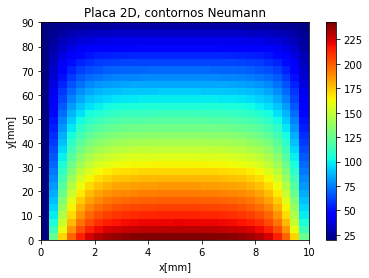

[  20.           20.           20.           20.           20.
   20.           20.           20.           20.           20.
   20.           20.           20.           20.           20.
   20.           20.           20.           20.           20.
   20.           20.           20.           20.           20.
   20.           20.           20.           20.           20.
   20.         2423.29162408 1338.98823014  710.40135539  360.3344759
  176.01259915   86.95644477   50.0962561    39.85263426   41.60031446
   47.41694711   53.36068898   57.75947707   60.1611916    60.70894184
   59.78471044   57.81842958   55.19592428   52.22346329   49.12270648
   46.04028057   43.06288879   40.23303088   37.56293909   35.04580867
   32.66420842   30.39595501   28.21789292   26.10804639   24.04656771
   22.01583722   20.         2488.11614418 1397.06022804  759.3983067
  402.15721093  213.46269713  122.3689567    84.95512893   74.84719781
   76.83704637   82.64792607   88.17128534   91.69983245

In [32]:
def I(x,y):
    return 20

solver_dense(I,"Al", 0, 10, 90, 30, 30, 1, 100,"N", q=10 , theta=0.5, U_0x=20, U_0y=20, U_Lx=20, U_Ly=20, user_action=None)


In [25]:
test = np.array([1,2,3])
test.size

3